## Correlation: &thinsp; DOC and wap

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import skimage.measure as skm
import seaborn as sns
import scipy
from scipy import stats

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import os
import sys
home = os.path.expanduser("~") + '/Documents'
sys.path.insert(0, '{}/code/phd/functions'.format(home))
from myFuncs import *

plt.rcParams['figure.figsize'] = [10, 7.5]

### one dataset

In [3]:
variable = 'wap500'

org_options = [
    'rome',
    # 'ni'
    ]

models_cmip5 = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3  no wap data
    # 'bcc-csm1-1',   # 4  only monthly wap (for rcp)
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6  only monthly wap
    # 'HadGEM2-AO',   # 7  only monthly wap
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9  no wap data
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13 only monthly wap
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 only monthly wap
    ]

models_cmip6 = [     
    # 'TaiESM1',        # 1
    # 'BCC-CSM2-MR',    # 2
    # 'FGOALS-g3',      # 3
    # 'CNRM-CM6-1',     # 4
    # # 'MIROC6',         # 5
    # 'MPI-ESM1-2-HR',  # 6
    # 'NorESM2-MM',     # 7
    # 'GFDL-CM4',       # 8
    # 'CanESM5',        # 9
    # 'CMCC-ESM2',      # 10
    # 'UKESM1-0-LL',    # 11
    # 'MRI-ESM2-0',     # 12
    # 'CESM2',          # 13
    # 'NESM3'           # 14
    ]
datasets = models_cmip5 + models_cmip6

resolutions = [
    # 'original',
    'regridded'
    ]

experiments = [
    'historical',
    # 'rcp85', 
    # 'ssp585'
    ]

print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(variable, datasets[0], experiments[0], resolutions[0]))
ds = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])
ds

variable:wap500, dataset:GFDL-CM3, experiment:historical, resolution:regridded


<xarray.Dataset>
Dimensions:  (time: 10950, lat: 22, lon: 128)
Coordinates:
    plev     float64 ...
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    wap500   (time, lat, lon) float32 ...

In [4]:
data = ds[variable]
data

<xarray.DataArray 'wap500' (time: 10950, lat: 22, lon: 128)>
[30835200 values with dtype=float32]
Coordinates:
    plev     float64 5e+04
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    regrid_method:  conservative
    units:          hPa day⁻¹

In [5]:
org = get_metric(org_options[0], datasets[0], experiments[0], resolution=resolutions[0])[org_options[0]]
org

<xarray.DataArray 'rome' (time: 10950)>
array([ 683534.434225,  880457.953047,  817436.978227, ..., 1267915.787371,
        827632.541006,  978485.728019])
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Attributes:
    units:    km^2

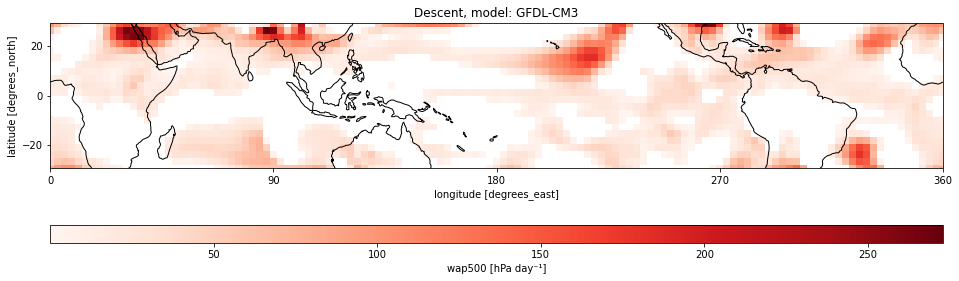

In [6]:
data_options = [
    # 'ascent',
    'descent'
    ]

data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
scene = data.isel(time=0)
if data_options[0] == 'ascent':
    cmap = 'Blues_r'
    title = 'ascent, model: {}'.format(datasets[0])
    plot_scene(scene.where(scene<0), cmap = cmap, title = title)
    data = data.where(data<0)

if data_options[0] == 'descent':
    cmap = 'Reds'
    title = 'Descent, model: {}'.format(datasets[0])
    plot_scene(scene.where(scene>0), cmap = cmap, title = title)
    data = data.where(data>0)

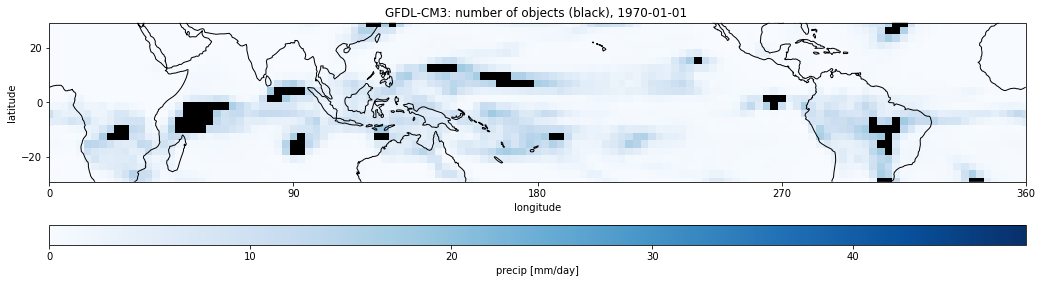

In [7]:
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black), ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')
plt.show()

#### values

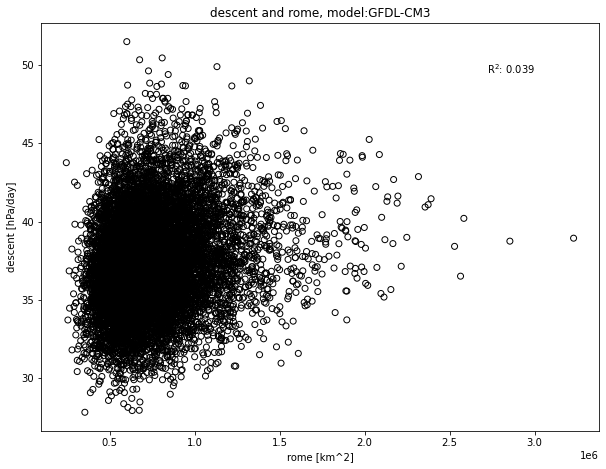

In [8]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

x = resample_timeMean(org, timeMean_options[0])
aWeights = np.cos(np.deg2rad(data.lat))
y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
y = y.assign_coords(time=x.time)

mix_of_daily_monthly = False 
if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = y.assign_coords(time=x.time)
    
fig = plt.figure()
ax= fig.add_subplot()
plot_scatter(x, y, ax)
plt.title('{} and {}, model:{}'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], 'hPa/day'))
plt.show()

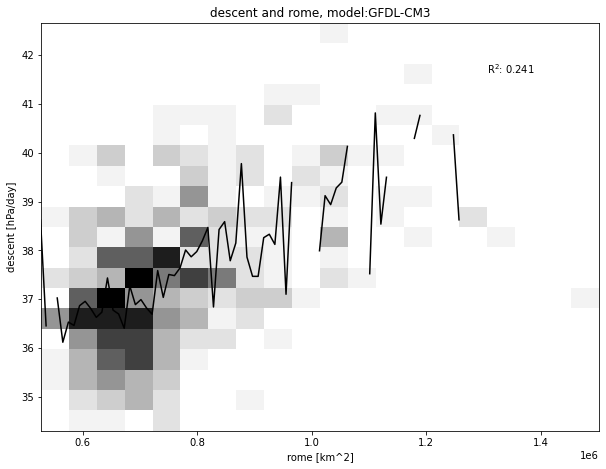

In [9]:
timeMean_options = [
    # 'annual',
    'monthly',
    # 'daily'
    ]

x = resample_timeMean(org, timeMean_options[0])
aWeights = np.cos(np.deg2rad(data.lat))
y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
y = y.assign_coords(time=x.time)

if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = y.assign_coords(time=x.time)

fig = plt.figure()
ax= fig.add_subplot()

plt.hist2d(x,y,[20,20], cmap ='Greys') #, vmin=0, vmax=300)
plot_bins(x,y, ax)

plt.title('{} and {}, model:{}'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], 'hPa/day'))
plt.show()

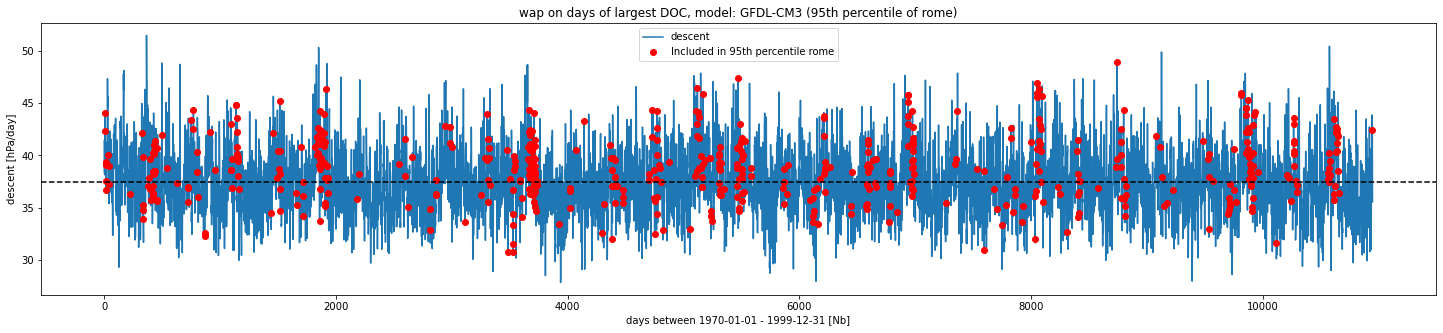

In [10]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

x_threshold = 95


x = resample_timeMean(org, timeMean_options[0])
aWeights = np.cos(np.deg2rad(data.lat))
y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
y = y.assign_coords(time=x.time)


if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = y.assign_coords(time=x.time)


x_prctile = np.percentile(x, x_threshold)
x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

x_data= np.arange(0,len(y))

f, ax = plt.subplots(figsize = (25,5))
title = 'wap on days of largest DOC, model: {} ({}th percentile of {})'.format(datasets[0], str(x_threshold), org_options[0])
label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

ax.plot(x_data,y, zorder=0,label=data_options[0])
ax.scatter(x_org, y[x_org], label=label, color='r')
ax.axhline(y=np.mean(y), color='k', linestyle = '--')
ax.set_title(title)


ax.set_xlabel('days between ' + str(data.coords['time'][0].values)[:10] 
              +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]')
ax.set_ylabel('{} [{}]'.format(data_options[0], 'hPa/day'))
ax.legend()

#### anomalies

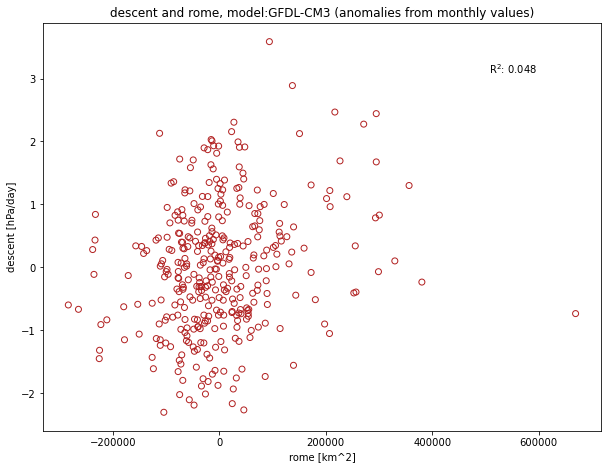

In [11]:
timeMean_options = [
    'monthly'
    ]

f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 

climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 

fig = plt.figure()
ax= fig.add_subplot()
plot_scatter(x, y, ax, 'firebrick')
plt.title('{} and {}, model:{} (anomalies from monthly values)'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], 'hPa/day'))
plt.show()

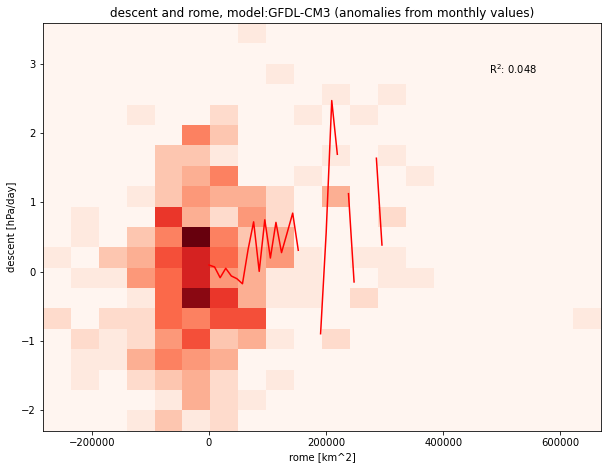

In [12]:
timeMean_options = [
    'monthly',
    ]

f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 

climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 


fig = plt.figure()
ax= fig.add_subplot()

plt.hist2d(x,y,[20,20], cmap = 'Reds') #, vmin=0, vmax=300)
plot_bins(x,y, ax, 'r')

plt.title('{} and {}, model:{} (anomalies from monthly values)'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], 'hPa/day'))
plt.show()

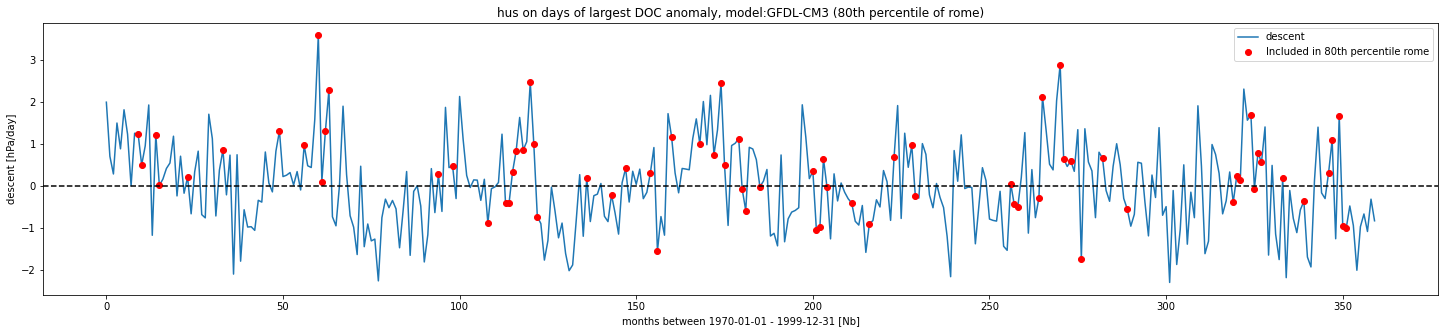

In [13]:
timeMean_options = [
    'monthly',
    ]

x_threshold = 80


f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 

climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 


x_prctile = np.percentile(x, x_threshold)
x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

x_data= np.arange(0,len(y))

f, ax = plt.subplots(figsize = (25,5))
title = 'hus on days of largest DOC anomaly, model:{} ({}th percentile of {})'.format(datasets[0], str(x_threshold), org_options[0])
label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

ax.plot(x_data,y, zorder=0,label=data_options[0])
ax.scatter(x_org, y[x_org], label=label, color='r')
ax.axhline(y=np.mean(y), color='k', linestyle = '--')
ax.set_title(title)


ax.set_xlabel('months between ' + str(data.coords['time'][0].values)[:10] 
              +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]')
ax.set_ylabel('{} [{}]'.format(data_options[0], 'hPa/day'))
ax.legend()

### comparing datasets (values)

In [14]:
variable = 'wap500'

data_options = [
    # 'ascent',
    'descent'
    ]

org_options = [
    'rome',
    # 'ni'
    ]

models_cmip5 = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3  no wap data
    # 'bcc-csm1-1',   # 4  only monthly wap (for rcp)
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6  only monthly wap
    # 'HadGEM2-AO',   # 7  only monthly wap
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9  no wap data
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    # 'inmcm4',       # 13 only monthly wap
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 only monthly wap
    ]


models_cmip6 = [     
    # 'TaiESM1',        # 1
    # 'BCC-CSM2-MR',    # 2
    # 'FGOALS-g3',      # 3
    # 'CNRM-CM6-1',     # 4
    # 'MIROC6',         # 5
    # 'MPI-ESM1-2-HR',  # 6
    # 'NorESM2-MM',     # 7
    # 'GFDL-CM4',       # 8
    # 'CanESM5',        # 9
    # 'CMCC-ESM2',      # 10
    # 'UKESM1-0-LL',    # 11
    # 'MRI-ESM2-0',     # 12
    # 'CESM2',          # 13
    # 'NESM3'           # 14
    ]

datasets = models_cmip5 + models_cmip6

mix_of_daily_monthly = False 

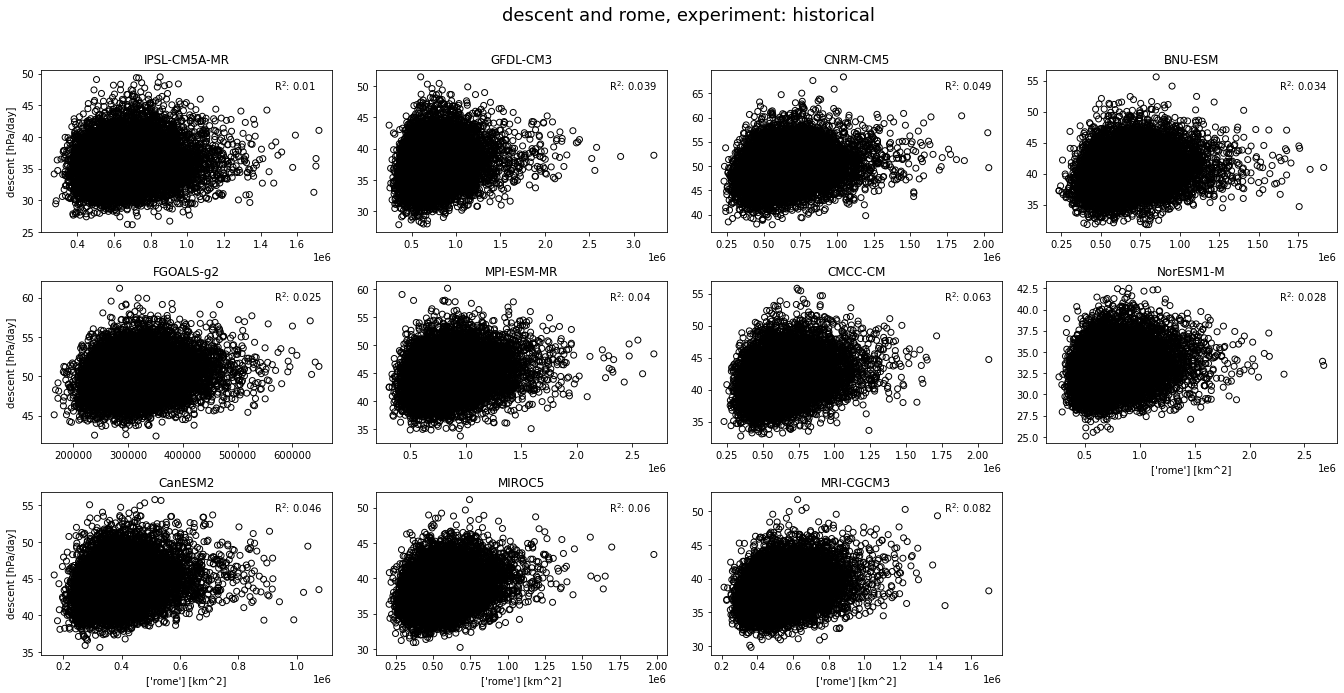

In [15]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:        
        data = get_dsvariable(variable, dataset, experiments[0], home, resolutions[0])[variable]
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        aWeights = np.cos(np.deg2rad(data.lat))
        y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
        y = y.assign_coords(time=x.time)

        if mix_of_daily_monthly and len(data) >1000: 
                data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
                data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
                if data_options[0] == 'ascent':
                    data = data.where(data<0)
                if data_options[0] == 'descent':
                    data = data.where(data>0)
                y = data.weighted(aWeights).mean(dim=('lat','lon')) 
                y = y.assign_coords(time=x.time)

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {}'.format(data_options[0], org_options[0], experiments[0])
fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], home, resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])

    data = get_dsvariable(variable, dataset, experiments[0], home, resolutions[0])[variable]
    if data_options[0] == 'ascent':
        data = data.where(data<0)
    if data_options[0] == 'descent':
        data = data.where(data>0)
    aWeights = np.cos(np.deg2rad(data.lat))
    y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
    y = y.assign_coords(time=x.time)

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
            data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            y = data.weighted(aWeights).mean(dim=('lat','lon')) 
            y = y.assign_coords(time=x.time)

    plot_scatter(x, y , ax)
    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], 'hPa/day')
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

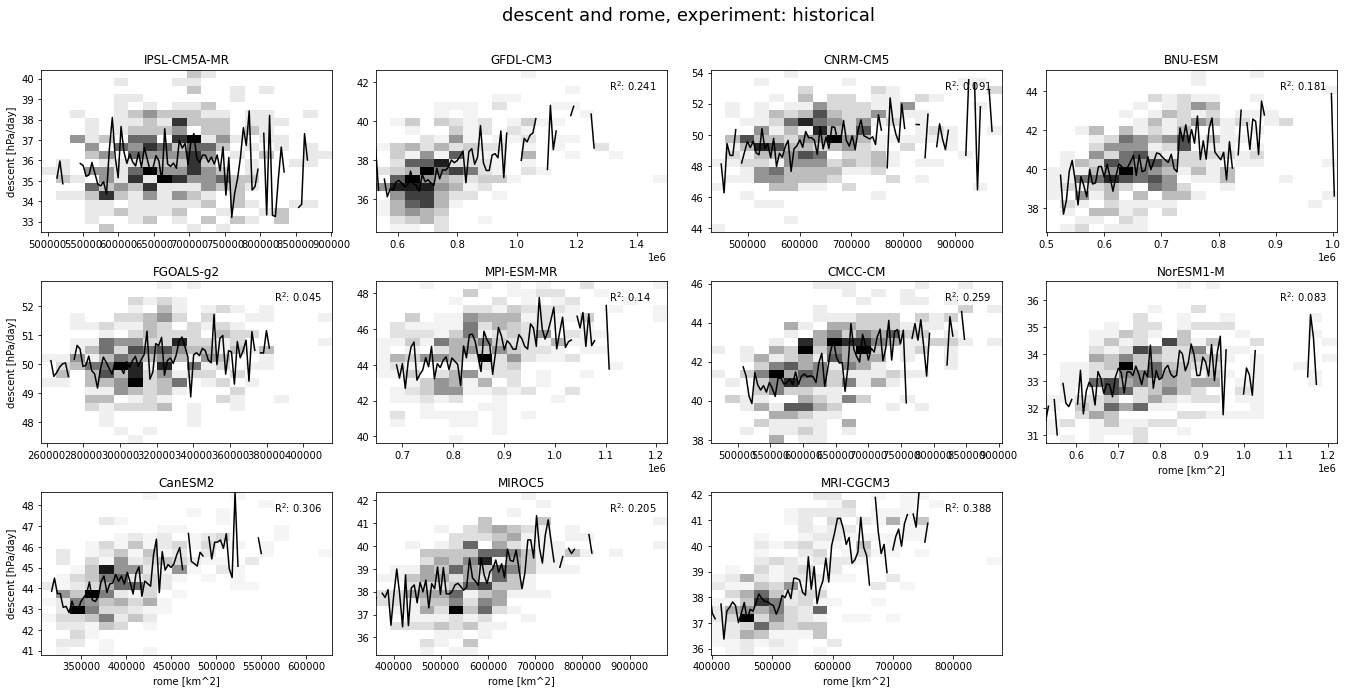

In [16]:
timeMean_options = [
    # 'annual',
    'monthly',
    # 'daily'
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:
        data = get_dsvariable(variable, dataset, experiments[0], home, resolutions[0])[variable]
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        aWeights = np.cos(np.deg2rad(data.lat))
        y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
        y = y.assign_coords(time=x.time)

        if mix_of_daily_monthly and len(data) >1000: 
                data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
                data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
                if data_options[0] == 'ascent':
                    data = data.where(data<0)
                if data_options[0] == 'descent':
                    data = data.where(data>0)
                y = data.weighted(aWeights).mean(dim=('lat','lon')) 
                y = y.assign_coords(time=x.time)

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {}'.format(data_options[0], org_options[0], experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])


    data = get_dsvariable(variable, dataset, experiments[0], home, resolutions[0])[variable]
    if data_options[0] == 'ascent':
        data = data.where(data<0)
    if data_options[0] == 'descent':
        data = data.where(data>0)
    aWeights = np.cos(np.deg2rad(data.lat))
    y = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])
    y = y.assign_coords(time=x.time)

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
            data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            y = data.weighted(aWeights).mean(dim=('lat','lon')) 
            y = y.assign_coords(time=x.time)


    plt.hist2d(x,y,[20,20], cmap ='Greys') #, vmin=0, vmax=300)
    plot_bins(x,y, ax)

    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options[0], org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], 'hPa/day')
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

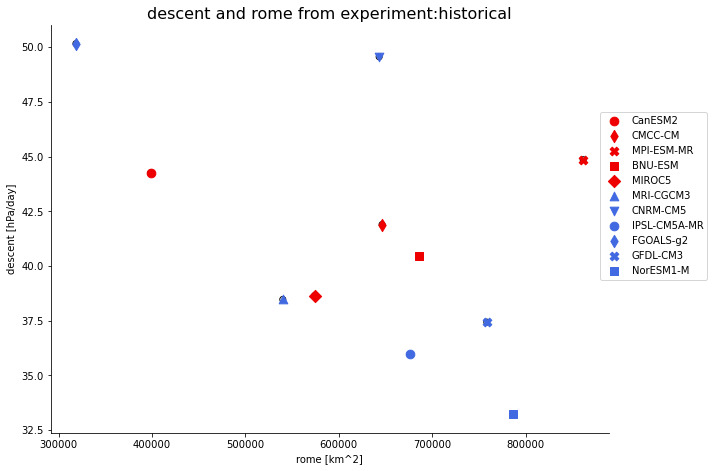

In [72]:
order, colors = orderByTas(True, datasets, experiments[0], resolutions[0])

x= []
y= []
for dataset in datasets:
    org = get_metric(org_options[0], dataset, experiments[0], home, resolutions[0])[org_options[0]]
    x_data = org.mean(dim=('time'))
    x = np.append(x, x_data)

    data = get_dsvariable(variable, dataset, experiments[0], home, resolutions[0])[variable]
    if data_options[0] == 'ascent':
        data = data.where(data<0)
    if data_options[0] == 'descent':
        data = data.where(data>0)
    aWeights = np.cos(np.deg2rad(data.lat))
    y_data = data.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time')

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
            data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            y_data = data.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time')

    y = np.append(y, y_data)

fig, ax = plt.subplots()
title = '{} and {} from experiment:{}'.format(data_options[0], org_options[0], experiments[0])
xlabel = '{} [{}]'.format(org_options[0], org.units)
ylabel = '{} [{}]'.format(data_options[0], 'hPa/day')

plot_scatter(x,y,ax)

labels = datasets
if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()
    
    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    
    plt.legend(bbox_to_anchor=(0.975,0.8))

sns.despine(top=True, right=True, left=False)
plt.title(title, fontsize = 16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

### with warming

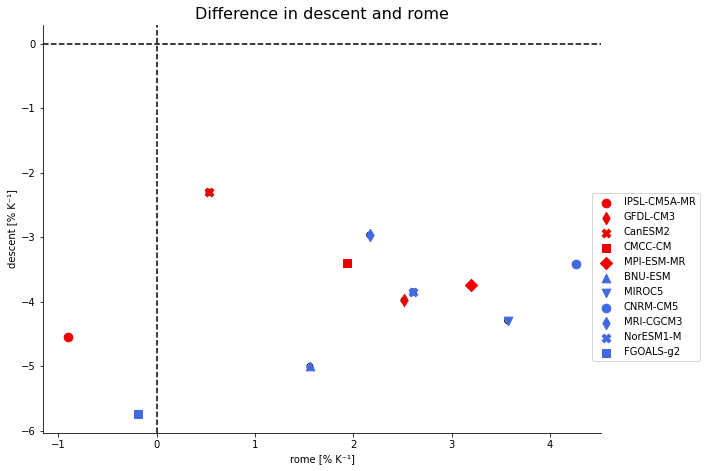

In [73]:
order, colors = orderByTasdiff(True, datasets, models_cmip5, resolutions[0])

x= []
y= []
for dataset in datasets:
    x_historical = get_metric(org_options[0], dataset, experiment = 'historical', resolution=resolutions[0])[org_options[0]].mean(dim=('time'))
    x_rcp = get_metric(org_options[0], dataset, experiment = 'rcp85', resolution=resolutions[0])[org_options[0]].mean(dim=('time'))
    xdiff = x_rcp - x_historical

    data = get_dsvariable(variable, dataset, experiment = 'historical', resolution = resolutions[0])[variable]
    if data_options[0] == 'ascent':
        data = data.where(data<0)
    if data_options[0] == 'descent':
        data = data.where(data>0)
    aWeights = np.cos(np.deg2rad(data.lat))
    data_historical = data.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time')

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, dataset, experiment = 'historical', resolution = resolutions[0])[variable]
            data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            data_historical = data.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time')

    data = get_dsvariable(variable, dataset, experiment = 'rcp85', resolution = resolutions[0])[variable]
    if data_options[0] == 'ascent':
        data = data.where(data<0)
    if data_options[0] == 'descent':
        data = data.where(data>0)
    aWeights = np.cos(np.deg2rad(data.lat))
    data_rcp = data.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time')

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, dataset, experiment = 'rcp85', resolution = resolutions[0])[variable]
            data = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            data_rcp = data.weighted(aWeights).mean(dim=('lat','lon')).mean(dim='time')

    datadiff = data_rcp - data_historical

    fractional_change = True
    if fractional_change:
        datadiff = (datadiff/data_historical)*100
        xdiff = (xdiff/x_historical)*100

    divide_by_tasdiff = True
    if divide_by_tasdiff:
        tas_historical = get_metric('tas_sMean', dataset, experiment='historical', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tas_rcp = get_metric('tas_sMean', dataset, experiment='rcp85', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tasdiff = tas_rcp - tas_historical
        datadiff = datadiff/tasdiff
        xdiff = xdiff/tasdiff

    x = np.append(x, xdiff)
    y = np.append(y, datadiff)

fig, ax = plt.subplots()
title = 'Difference in {} and {}'.format(data_options[0], org_options[0])
xlabel = '{} [{}]'.format(org_options[0], '%' + ' K' + chr(0x207B) + chr(0x00B9))
ylabel = '{} [{}]'.format(data_options[0], '%' + ' K' + chr(0x207B) + chr(0x00B9))

plot_scatter(x,y,ax)


labels = datasets
if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()
    
    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    
    plt.legend(bbox_to_anchor=(0.975,0.6))

sns.despine(top=True, right=True, left=False)
plt.axvline(0, color= 'k',  linestyle="--")
plt.axhline(0, color= 'k',  linestyle="--")
plt.title(title, fontsize = 16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

### comparing datasets (anomalies)

In [ ]:
f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

if mix_of_daily_monthly and len(data) >1000: 
        data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
        f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
        if data_options[0] == 'ascent':
            data = data.where(data<0)
        if data_options[0] == 'descent':
            data = data.where(data>0)
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 

climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 

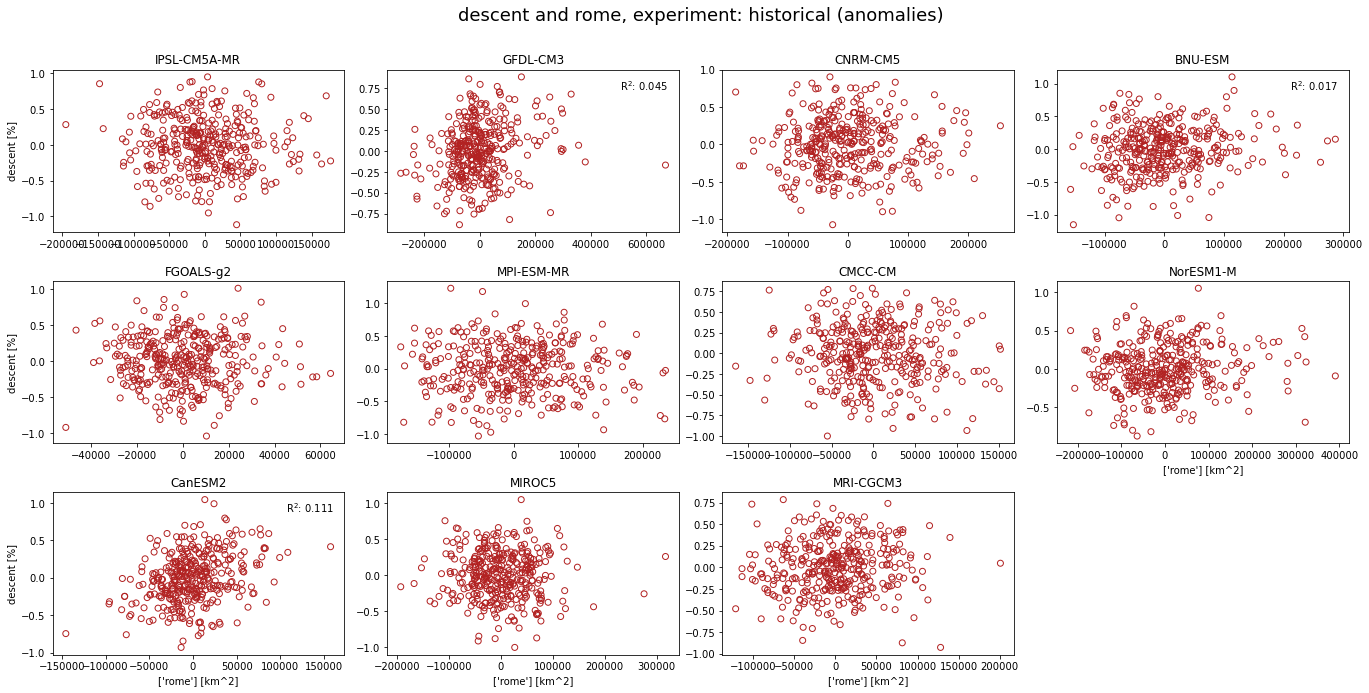

In [74]:
timeMean_options = [
    'monthly',
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        f = resample_timeMean(org, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        x = f.groupby('time.month') - climatology 

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[variable]
        aWeights = np.cos(np.deg2rad(data.lat))
        f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

        if mix_of_daily_monthly and len(data) >1000: 
                data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
                f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
                if data_options[0] == 'ascent':
                    data = data.where(data<0)
                if data_options[0] == 'descent':
                    data = data.where(data>0)
                f = data.weighted(aWeights).mean(dim=('lat','lon')) 

        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {} (anomalies)'.format(data_options[0], org_options[0], experiments[0])
fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    f = resample_timeMean(org, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    x = f.groupby('time.month') - climatology 

    data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[variable]
    aWeights = np.cos(np.deg2rad(data.lat))
    f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
            f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            f = data.weighted(aWeights).mean(dim=('lat','lon')) 

    climatology = f.groupby('time.month').mean('time')
    y = f.groupby('time.month') - climatology 


    plot_scatter(x, y , ax, 'firebrick')
    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], '%')
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

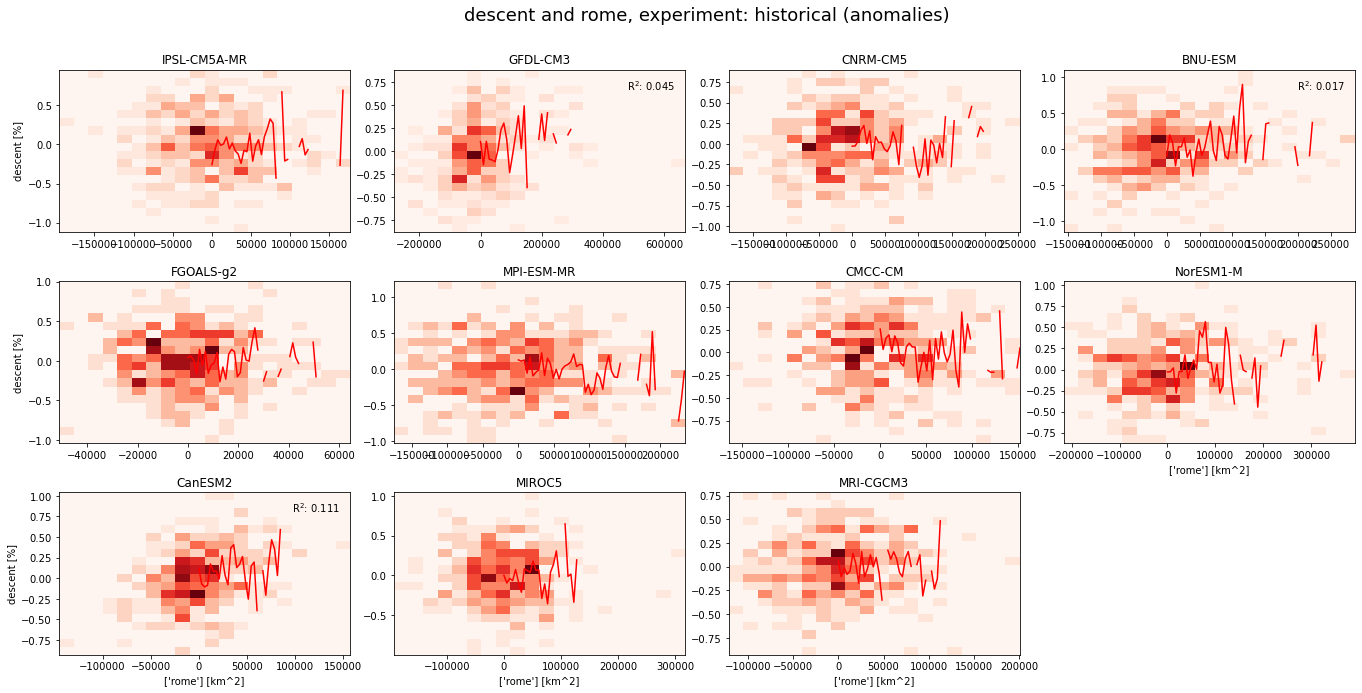

In [75]:
timeMean_options = [
    'monthly',
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        f = resample_timeMean(org, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        x = f.groupby('time.month') - climatology 

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:
        data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[variable]
        aWeights = np.cos(np.deg2rad(data.lat))
        f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

        if mix_of_daily_monthly and len(data) >1000: 
                data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
                f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
                if data_options[0] == 'ascent':
                    data = data.where(data<0)
                if data_options[0] == 'descent':
                    data = data.where(data>0)
                f = data.weighted(aWeights).mean(dim=('lat','lon')) 

        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {} (anomalies)'.format(data_options[0], org_options[0], experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    f = resample_timeMean(org, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    x = f.groupby('time.month') - climatology 

    data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[variable]
    aWeights = np.cos(np.deg2rad(data.lat))
    f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
            f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            f = data.weighted(aWeights).mean(dim=('lat','lon')) 

    climatology = f.groupby('time.month').mean('time')
    y = f.groupby('time.month') - climatology 

    plt.hist2d(x,y,[20,20], cmap = 'Reds') #, vmin=0, vmax=300)
    plot_bins(x,y, ax, 'r')
    
    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], '%')
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

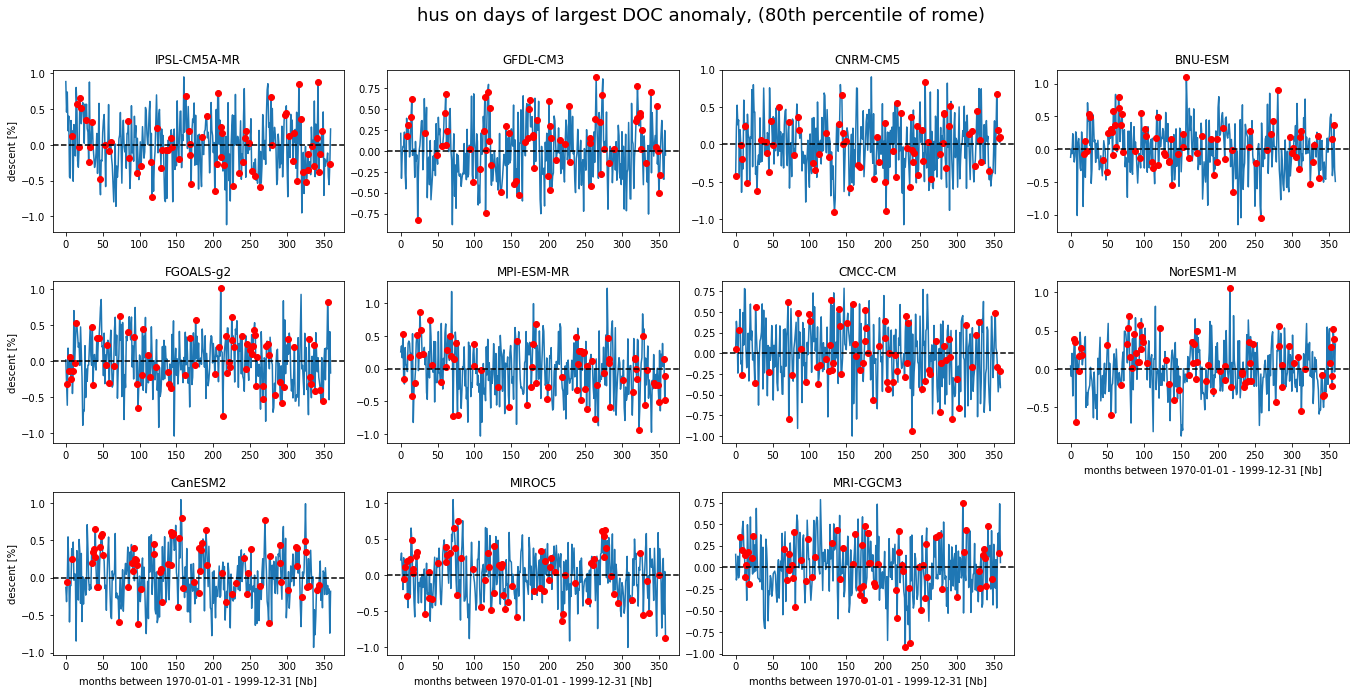

In [76]:
timeMean_options = [
    'monthly',
    ]


x_threshold = 80



quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:
        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        f = resample_timeMean(org, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        x = f.groupby('time.month') - climatology 

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:
        data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[variable]
        aWeights = np.cos(np.deg2rad(data.lat))
        f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

        if mix_of_daily_monthly and len(data) >1000: 
                data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
                f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
                if data_options[0] == 'ascent':
                    data = data.where(data<0)
                if data_options[0] == 'descent':
                    data = data.where(data>0)
                f = data.weighted(aWeights).mean(dim=('lat','lon')) 

        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = 'hus on days of largest DOC anomaly, ({}th percentile of {})'.format(str(x_threshold), org_options[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    f = resample_timeMean(org, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    x = f.groupby('time.month') - climatology 

    data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[variable]
    aWeights = np.cos(np.deg2rad(data.lat))
    f = resample_timeMean(data.weighted(aWeights).mean(dim=('lat','lon')) , timeMean_options[0])

    if mix_of_daily_monthly and len(data) >1000: 
            data = get_dsvariable(variable, datasets[0], experiments[0], home, resolutions[0])[variable]
            f = resample_timeMean(data, timeMean_options[0]) # matters as gridpoints with daily value can be excluded if taking the monthyl gridbox mean first
            if data_options[0] == 'ascent':
                data = data.where(data<0)
            if data_options[0] == 'descent':
                data = data.where(data>0)
            f = data.weighted(aWeights).mean(dim=('lat','lon')) 

    climatology = f.groupby('time.month').mean('time')
    y = f.groupby('time.month') - climatology 


    x_prctile = np.percentile(x, x_threshold)
    x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

    x_data= np.arange(0,len(y))

    label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

    ax.plot(x_data,y, zorder=0,label=data_options[0])
    ax.scatter(x_org, y[x_org], label=label, color='r')
    ax.axhline(y=np.mean(y), color='k', linestyle = '--')

    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = 'months between ' + str(data.coords['time'][0].values)[:10] +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]'
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], '%')
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)